# Midterm assignment, topic 1
# Consumer choice and consumer demand

---

### Background and references

In this assignment you consider a classic consumer choice setup given by the utility function and budget constraint, and numerically derive the demand function.

* Hal Varian "Microeconomic analysis", 3 ed. 1992, Chapter 7, 8  
https://books.google.com.au/books/about/Microeconomic_Analysis.html?id=m20iQAAACAAJ&redir_esc=y
* https://en.wikipedia.org/wiki/Consumer_choice
* https://en.wikipedia.org/wiki/Inferior_good


---

The sequence of tasks below should be performed in order in this notebook.  Feel free to add code and markdown cells, add picture, etc, to facilitate your presentation of this work in the class. The tasks below are often up to some degree of interpretation (so, don't tell you what to do exactly), you are free to interpret them in the way you see fit best. But remember to explain why you make such and such choices when you present your work.

The grade for the midterm assignment is based on both the code correctness and code style. The former relates to whether the code adequately represents the economic model under consideration, and the latter has to do with how well the code is modularized and organized, whether appropriate syntax is used, and whether the code is well documented. [PEP 8](https://www.python.org/dev/peps/pep-0008/) standard is a good reference for coding style, but will not inhibit the grade.

The completed notebook should be used in the class to present your model, demonstrate your code and explain your design decisions.

---

### 1. Make a short introduction to the consumer choice setup
- Use references above

### 2. Design and implement a Python class to represent the model
- Use constant elasticity of substitution (CES) utility function to represent preferences over two goods

$$
u(x,y) = \Big( a_1 x^{\frac{s-1}{s}} + a_2 y^{\frac{s-1}{s}} \Big)^{\frac{s}{s-1}}
$$

- Allow prices of the goods be $p_1$ and $p_2$, and budget constraint (assuming no money wasted) 
$B = x p_1 + y p_2$

- Design the attributes of the class and implement *init* and *repr* methods. Implement other methods according to your design.

- Make a *plot_preferences* method for the class to illustrate the preferences represented the objects of the class, and illustrate how the parameters of the utility function affect the plot. Give economic interpretation for the parameters. (To make possible the figure with one of the indifference curves touching the budget constraint, make sure that this procedure can plot the indifference curves for a particular value of utility, or array of such values.)

- Make a *plot_budget* method for the class to illustrate the budget of the consumer. (Again, to make possible later figures, make sure that two plotting methods can create plots on the same axes).

- Finally, write a *solve* method which would numerically solve the consumer choice problem and return the optimal bundle of goods. Use an unconstrained solver and provide it with an analytical gradient.  The constrained consumer choice problem can be reformulated as unconstrained with the assumption of full budget utilization by simple substitution.

### 3. By drawing several diagrams that illustrate optimal consumer choice using your class, investigate and describe how parameters of the preferences affect the optimal choice.
- Try finding and considering a few characteristic extremal cases that would give an idea of the boundaries for the set of solutions.
- Give economic intuition for the observed differences.

### 4. Code up a function which takes a model object as input argument, and creates a series of pictures to illustrate how optimal consumer choice changes with changing prices to give rise to demand curve.
- Implement a way to change the number of the produced picture (and detail of the illustration) with some input argument, and let the function output the produced series of optimal choices for different prices.
- Produce an example of running the developed function, and classify the two goods into normal and inferior.
- Find values for the preference parameters that correspond to inferior good, and make the corresponding illustration.

### 5. Repeat the same exercise for changing budget to illustrate the income effect in consumer choice.
- Decide and argue to either modify the already written function or creating a new one.
- Produce an illustration of the Giffen good.

### 6. Run a Monte Carlo exercises to approximate the subsets of parameter space that correspond to the inferior and Giffen goods.
- First, impose the restriction to parameters $a_2 = 1-a_1$, which makes parameter $a_2$ disappear. Then, with parameters given by $(a_1,s)$, we can plot parameters on a plane.
- Choose a range for parameters, and proceed with the simulation using uniform distribution.
- Present the results graphically with points on the $(a_1,s)$ plane colored differently for the four combination of good classes (normal-inferior and nonormal-Giffen).
- Discuss the observed patterns

# Question 2

In [17]:
# Question 2: Defining the class to represent the model
import math
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from ipywidgets import interact

class consumer_choice():
    
    '''Class of demand for goods with CES utility function'''
    
    def __init__(self, q1 =1.0, label = 'Consumer choice',
                                        s = 1.5,  # elasticity of substitution                                        
                                        a1 = 0.3,  # share parameter for good 1
                                        a2 = 0.7,  # share parameter for good 2
                                        I = 100,     # Income or budget
                                        U_bar = 100,  # Utility
                                        p1 = 2,      # Price for good 1
                                        p2 = 3) :     # Price for good 2
        self.q1, self.s, self.a1, self.a2, self.I, self.U_bar, self.p1, self.p2 = q1, s, a1, a2, I, U_bar, p1, p2
    def __repr__(self): 
        '''Representation of the model object'''
        return 'Consumer choice represented by CES utility function with share parameters  %r, %1.2f' % (self.a1,self.a2)
            

    def utility(self, q1):
        self.q1 = q1
        b = (self.s-1)/self.s
        U = ((self.a1*self.q1**b) + self.a2*((self.I-self.q1*self.p1)/self.p2)**b)**(1/b)
        return U
    
    def plot_budget(self, I, p1, p2):
        '''Method to illustrate budget constraint of the consumer'''
        self.I, self.p1, self.p2 = I, p1, p2
        q1 = np.linspace(0, I/p1, 10)
        q2 = I/p2- (p1/p2)*q1
        fig, ax = plt.subplots()  # Create axes and figure window
        ax.plot(q1, q2, 'b-')
        return plt.show()
      
    def plot_preferences(self, U_bar, s, a1, a2):
        self.U_bar, self.s, self.a1, self.a2 = U_bar, s, a1, a2
        '''Method to illustrate indifference curve of the consumer'''
        q1 = np.linspace(0, self.I/self.p1, 100)
        q2 = ((U_bar**((s-1)/s) - a1*q1**((s-1)/s))/a2)**(s/(s-1))
        fig, ax = plt.subplots()  # Create axes and figure window
        ax.plot(q1, q2, 'r-')
        return plt.show()
    
    def FOC(self,q1=1):
        '''Method to solve FOC'''
        self.q1 = q1
        b = (self.s-1)/self.s # just short hand for (s-1)/s
        A = ((self.a1*self.q1**b) + self.a2*((self.I-self.q1*self.p1)/self.p2)**b)
        FOC = A**((1/b)-1)*(self.a1*self.q1**(b-1)-self.a2*((self.I-self.q1*self.p1)/self.p2)**(b-1)*(self.p1/self.p2))
        return FOC
    
    def plot_solution(self, q1, I, p1, p2, U_bar, s, a1, a2):
        '''Method to solve for the root of FOC and plot the solution'''
        self.q1, self.I, self.p1, self.p2, self.U_bar, self.s, self.a1, self.a2 = q1, I, p1, p2, U_bar, s, a1, a2
        q1_opt = optimize.root(self.FOC, self.q1)
        U_opt = self.utility(q1 = q1_opt.x)
        self.plot_budget(I=self.I, p1=self.p1, p2=self.p2)
        self.plot_preferences(U_bar = U_opt, s=self.s, a1=self.a1, a2=self.a2)
 


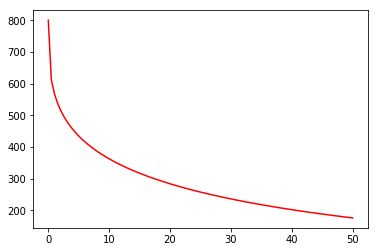

interactive(children=(FloatSlider(value=500.005, description='U_bar', max=1000.0, min=0.01), FloatSlider(value=2.2, description='s', max=4.2, min=0.2), FloatSlider(value=5.05, description='a1', max=10.0, min=0.1), FloatSlider(value=5.05, description='a2', max=10.0, min=0.1), Output()), _dom_classes=('widget-interact',))

In [18]:
m=consumer_choice()
m.plot_preferences(U_bar=100, s=1.5, a1=0.5, a2=0.5)
interact(m.plot_preferences, 
              U_bar=(0.01, 1000),
              a1=(0.1, 10),
              a2=(0.1, 10),
              #self.p1=(1,100), 
              #self.p2=(1.0,1.5), 
              s=(0.2,4.2), 
              #I=(0.1, 1000),
             )
plt.show()

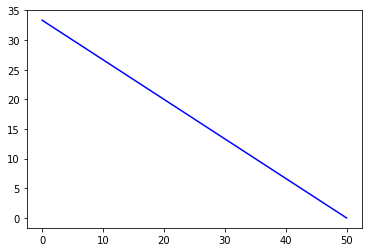

interactive(children=(FloatSlider(value=500.05, description='I', max=1000.0, min=0.1), IntSlider(value=50, description='p1', min=1), FloatSlider(value=50.5, description='p2', min=1.0), Output()), _dom_classes=('widget-interact',))

In [19]:
m.plot_budget(I=100, p1=2, p2=3)
interact(m.plot_budget, 
              p1=(1,100), 
              p2=(1.0,100), 
              s=(0.2,4.2), 
              I=(0.1, 1000),
             )
plt.show()

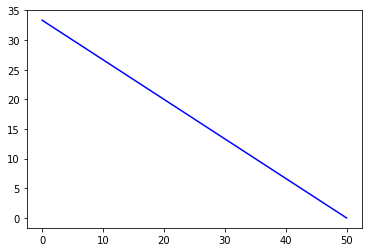

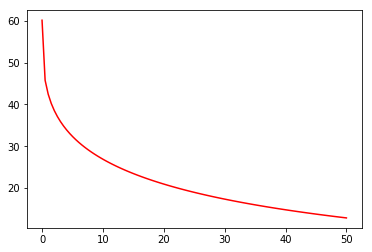

In [20]:
m.plot_solution(q1 =1.0,s = 1.5, a1 = 0.3, a2 = 0.7, I = 100,U_bar = 100, p1 = 2, p2 = 3)


# Question 3

# Question 4

# Question 5

# Question 6